In [41]:
import maup # mggg's library for proration, see documentation here: https://github.com/mggg/maup
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et

# Election Results

## Election Data Sources

Election results from the Secretary of State's office via OpenElections (https://github.com/openelections/openelections-data-mo/tree/master/2018). Absentee, provisional, and mail ballots were reported countywide in nearly every county; these were distributed by candidate to precincts based on their share of the precinct-level reported vote.

- G18USSRHAW - Josh Hawley (Republican Party)  
- G18USSDMCC - Claire McCaskill (Democratic Party)  
- G18USSLCAM - Japheth Campbell (Libertarian Party)  
- G18USSGCRA - Jo Crain (Green Party)  
- G18USSIODE - Craig O'Dear (Independent)  
  
  
- G18AUDRMCD - Saundra McDowell (Republican Party)  
- G18AUDDGAL - Nicole Galloway (Democratic Party)  
- G18AUDLOTO - Sean O'Toole (Libertarian Party)  
- G18AUDGFIT - Don Fitz (Green Party)  
- G18AUDCLUE - Jacob Luetkemeyer (Constitution Party)  


## Load Election Data

In [42]:
#Import VEST file
vest_mo_18 = gp.read_file("./raw-from-source/VEST/mo_2018/mo_2018.shp")

#Import elections file
mo_elections = pd.read_csv("./raw-from-source/Open_Elections/20181106__mo__general__precinct.csv")

#Clean names and filter down to relevant candidates and offices
candidate_list = ['Josh Hawley','Claire McCaskill','Japheth Campbell','Jo Crain',
 "Craig O'Dear",'Saundra McDowell','Nicole Galloway',"Sean O'Toole",'Don Fitz','Jacob Luetkemeyer']
office_list = ['U.S. Senate', 'State Auditor']
mo_elections["candidate"] = mo_elections["candidate"].str.strip()
mo_elections = mo_elections[mo_elections["office"].isin(office_list)]
mo_elections = mo_elections[mo_elections["candidate"].isin(candidate_list)]

#Load in FIPS data to change counties from names to fips
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Missouri"]
fips_file["FIPS County"] = fips_file["FIPS County"].astype(str)
fips_file["FIPS County"] = fips_file["FIPS County"].str.zfill(3)
fips_dict = dict(zip(fips_file['County Name'], fips_file['FIPS County']))
mo_changes = {'De Kalb':'Dekalb','Kansas City':'Jackson','McDonald':'Mcdonald',
              'St. Charles':'St Charles','St. Clair':'St Clair',
              'Ste. Genevieve':'Ste Genevieve','St. Francois':'St Francois',
              'St. Louis City':'St Louis City','St. Louis County':'St Louis'}
mo_elections['county'] = mo_elections['county'].map(mo_changes).fillna(mo_elections['county'])
mo_elections['COUNTYFP'] = mo_elections['county'].map(fips_dict).fillna(mo_elections['county'])
mo_elections["unique_ID"]=mo_elections["COUNTYFP"]+mo_elections["precinct"]

### Pivot Election Results and Change Precinct Names

In [43]:
#Pivot election results
mo_elections_pivot = pd.pivot_table(mo_elections,index=["unique_ID","COUNTYFP","precinct"],columns=["candidate"],values=['votes'],aggfunc=sum)

#Clean up dataframe NA values, index, and names
mo_elections_pivot = mo_elections_pivot.fillna(0)
mo_elections_pivot.columns = mo_elections_pivot.columns.droplevel(0)
mo_elections_pivot.reset_index(drop=False,inplace=True)
mo_elections_pivot = mo_elections_pivot.rename(columns={'Claire McCaskill':"G18USSDMCC","Craig O'Dear": "G18USSIODE",'Don Fitz':"G18AUDGFIT",'Jacob Luetkemeyer':"G18AUDCLUE",'Japheth Campbell':"G18USSLCAM",'Jo Crain':"G18USSGCRA",'Josh Hawley':"G18USSRHAW",'Nicole Galloway':"G18AUDDGAL",'Saundra McDowell':"G18AUDRMCD","Sean O'Toole":"G18AUDLOTO"})

#Change unique_ID names to match VEST final file
#matcher_increase is a CSV file that I created that has the name changes that VEST used
matcher_increase = pd.read_csv("./raw-from-source/matcher_increase.csv")
new_name_dict = dict(zip(matcher_increase['source_names'], matcher_increase['vest_names']))
mo_elections_pivot["unique_ID"] = mo_elections_pivot["unique_ID"].str.strip()
mo_elections_pivot["unique_ID"] = mo_elections_pivot["unique_ID"].map(new_name_dict).fillna(mo_elections_pivot["unique_ID"])

### Check totals before assigning countywide votes

Note: There seem to be minor differences in the totals (max of 15 in one column)

In [48]:
col_list = ["G18USSDMCC","G18USSIODE","G18AUDGFIT","G18AUDCLUE","G18USSLCAM","G18USSGCRA","G18USSRHAW","G18AUDDGAL","G18AUDRMCD","G18AUDLOTO"]
for i in col_list:
    print(i)
    print("For ", i,"diff of " + str(abs(sum(mo_elections_pivot[i])-sum(vest_mo_18[i]))))

G18USSDMCC
For  G18USSDMCC diff of 9.0
G18USSIODE
For  G18USSIODE diff of 0.0
G18AUDGFIT
For  G18AUDGFIT diff of 2.0
G18AUDCLUE
For  G18AUDCLUE diff of 0.0
G18USSLCAM
For  G18USSLCAM diff of 0.0
G18USSGCRA
For  G18USSGCRA diff of 2.0
G18USSRHAW
For  G18USSRHAW diff of 15.0
G18AUDDGAL
For  G18AUDDGAL diff of 2.0
G18AUDRMCD
For  G18AUDRMCD diff of 14.0
G18AUDLOTO
For  G18AUDLOTO diff of 0.0


### Assign Countywide Votes

In [4]:
kc_precincts = mo_elections_pivot[mo_elections_pivot["unique_ID"].str[0:5]=="095KC"]
remove_list = ["ABSENTEE","PROVISIONAL","FEDERAL","FEDERAL/STATE","INTRASTATE","WRITE-IN","CENTRAL POLLING LOCATION","CENTRAL POLL","ABSENTEE1","ABSENTEE2","VOTE CENTER","CENTRAL POLLING LOCATION: MSU","INTRASTATE/NEW RESIDENT","WRITE-INS","MULTI-PRECINCT COLLECTION","INTRASTATE NEW RESIDENT","MULTI-PRECINCT COLLECTION","ABSENTEE, PROVISIONAL & CENTRAL","INTRASTATE01","INTRASTATE02"]
mo_elections_countywide = mo_elections_pivot[(mo_elections_pivot["precinct"].isin(remove_list)) | (mo_elections_pivot["unique_ID"]=='019CENTRAL')]
mo_elections_pivot = mo_elections_pivot[~(mo_elections_pivot["precinct"].isin(remove_list)) & ~(mo_elections_pivot["unique_ID"]=='019CENTRAL') & ~(mo_elections_pivot["unique_ID"].str[0:5]=="095KC")]
countywide_totals = mo_elections_countywide.groupby(["COUNTYFP"]).sum()
precinct_totals = mo_elections_pivot.groupby(["COUNTYFP"]).sum()
data_to_add = pd.merge(precinct_totals,countywide_totals,on=['COUNTYFP'],how='left',indicator=False)
data_to_add.reset_index(inplace=True,drop=False)

joined = pd.merge(mo_elections_pivot,data_to_add,on=['COUNTYFP'],how='left',indicator=False)
joined = joined.fillna(0)
col_list = ["G18USSDMCC","G18USSIODE","G18AUDGFIT","G18AUDCLUE","G18USSLCAM","G18USSGCRA","G18USSRHAW","G18AUDDGAL","G18AUDRMCD","G18AUDLOTO"]
for i in col_list:
    precinct_totals = i + "_x"
    countywide_reported = i+"_y"
    joined[i]=round(joined[i]+((joined[i]*joined[countywide_reported])/joined[precinct_totals]),0)
joined = joined [["unique_ID","COUNTYFP","precinct","G18USSDMCC","G18USSIODE","G18AUDGFIT","G18AUDCLUE","G18USSLCAM","G18USSGCRA","G18USSRHAW","G18AUDDGAL","G18AUDRMCD","G18AUDLOTO"]]
joined = joined.append(kc_precincts)

### Deal with Empty Precincts

In [5]:
vest_mo_18["unique_ID"]=vest_mo_18["COUNTYFP"]+vest_mo_18["NAME"]
vest_empty = vest_mo_18[(vest_mo_18['G18USSRHAW']==0) & (vest_mo_18['G18USSDMCC']==0) &
              (vest_mo_18['G18USSLCAM']==0) & (vest_mo_18['G18USSGCRA']==0) &
              (vest_mo_18['G18USSIODE']==0) & (vest_mo_18['G18AUDRMCD']==0) &
              (vest_mo_18['G18AUDDGAL']==0) & (vest_mo_18['G18AUDLOTO']==0) &
              (vest_mo_18['G18AUDGFIT']==0) & (vest_mo_18['G18AUDCLUE']==0)]["unique_ID"]

joined_empty = joined[(joined['G18USSRHAW']==0) & (joined['G18USSDMCC']==0) &
              (joined['G18USSLCAM']==0) & (joined['G18USSGCRA']==0) &
              (joined['G18USSIODE']==0) & (joined['G18AUDRMCD']==0) &
              (joined['G18AUDDGAL']==0) & (joined['G18AUDLOTO']==0) &
              (joined['G18AUDGFIT']==0) & (joined['G18AUDCLUE']==0)]["unique_ID"]

print(joined_empty.head())

2161    189MER44
Name: unique_ID, dtype: object


In [6]:
#Create empty precincts for empty VEST precincts
new_precincts = pd.DataFrame(columns=joined.columns)
new_precincts["unique_ID"]=vest_empty
col_list = ["G18USSDMCC","G18USSIODE","G18AUDGFIT","G18AUDCLUE","G18USSLCAM","G18USSGCRA","G18USSRHAW","G18AUDDGAL","G18AUDRMCD","G18AUDLOTO"]
for i in col_list:
    new_precincts[i]=0
joined = joined.append(new_precincts)

### Check election results by joining to VEST final file

In [7]:
print(vest_mo_18.shape)
print(joined.shape)

#Note: Only one county did not join, but it is the empty one from above
final_join = pd.merge(vest_mo_18,joined,how="outer",on="unique_ID",indicator=True)
print(final_join["_merge"].value_counts())
print(final_join[final_join["_merge"]=="right_only"]["unique_ID"])

(3242, 15)
(3243, 13)
both          3242
right_only       1
left_only        0
Name: _merge, dtype: int64
3242    189MER44
Name: unique_ID, dtype: object


### Validate Election Results

In [8]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff != 0):
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]['unique_ID'])
                if (diff>max_diff):
                    max_diff = diff
                    print("New max diff is: ", str(max_diff))
                    print(df.iloc[j]['unique_ID'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]['unique_ID'])
        else:
            matching_rows +=1
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 5")
    diff_list.sort()

col_list = ["G18USSDMCC","G18USSIODE","G18AUDGFIT","G18AUDCLUE","G18USSLCAM","G18USSGCRA","G18USSRHAW","G18AUDDGAL","G18AUDRMCD","G18AUDLOTO"]
validater_row(final_join[final_join["_merge"]=="both"],col_list)

New max diff is:  1.0
043West Finley
New max diff is:  2.0
0194K/4M/37
There are  3242  total rows
1067  of these rows have election result differences
2175  of these rows are the same

The max difference between any one shared column in a row is:  2.0
The average difference is:  1.0192307692307692
There are  0 precinct results with a difference greater than 5


# Precinct Shapefiles

## Precinct Shapefile Sources

The documentation mentions 4 different sources for shapefiles:

1. Precinct shapefiles primarily from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release.  
2. Monroe County comes from the 2010 Census VTD release.  
3. Platte County comes from the 2020 Census VTD release.  
4. The following counties instead used maps or shapefiles sourced from the respective county governments: Audrain, Bates, Caldwell, Callaway, Camden, Cape Girardeau, Cedar, Cooper, Franklin, Greene, Jackson, Jasper, Jefferson, Laclede, Lafayette, Lawrence, Marion, McDonald, Miller, Nodaway, Osage, Ozark, Pemiscot, Pike, Randolph, Scott, Ste. Genevieve, Texas, Warren, Washington, Worth, Wright.  

### 1. U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release
> Precinct shapefiles primarily from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release.

https://www.census.gov/geo/partnerships/pvs/partnership19v2/st29_mo.html

In [9]:
#When downloading from the Census redistricing data program, these use a FIPS code to identify counties

fips_file["unique_ID"] =  "29" + fips_file["FIPS County"]
fips_codes = fips_file["unique_ID"].tolist()

#Combine all the data from separate files into one
li = []
for i in fips_codes:
    ref = "./raw-from-source/Census/2020_Phase_2/partnership_shapefiles_19v2_"
    file_ref = ref+i+"/PVS_19_v2_vtd_"+i+".shp"
    file_prev = gp.read_file(file_ref)
    #print(file_prev.shape)
    li.append(file_prev)
global shapefiles_census
shapefiles_census = pd.concat(li, axis=0, ignore_index=True)

In [10]:
county_list = ["Audrain", "Bates","Caldwell","Callaway","Camden","Cape Girardeau","Cedar","Cooper","Franklin","Greene","Jackson","Jasper","Jefferson", 
               "Laclede", "Lafayette","Lawrence", "Marion", "Mcdonald","Miller","Monroe","Nodaway",
               "Osage", "Ozark", "Pemiscot","Platte", "Pike", "Randolph", "Scott","Ste Genevieve", "Texas", "Warren", "Washington", "Worth", "Wright"]
fips_to_take = fips_file[fips_file["County Name"].isin(county_list)]
different_source = fips_to_take["FIPS County"].tolist()

shapefiles_census = shapefiles_census[~shapefiles_census["COUNTYFP"].isin(different_source)]

#Create a unique ID
shapefiles_census["unique_ID"] = shapefiles_census["COUNTYFP"]+shapefiles_census["NAME"]
shapefiles_census["unique_ID"] = shapefiles_census["unique_ID"].apply(lambda x: x.title() if (x[0:3]!="189" and x[0:3]!="510" and x[0:3]!="047" and x[0:3]!="159" and x[0:3]!="051" and x[0:3]!="217" and x[0:3]!="183" and x[0:3]!="009" ) else x)
shapefiles_census["unique_ID"] = shapefiles_census["unique_ID"].str.strip()

#Check if unique_ID value is unique
print(shapefiles_census["unique_ID"].value_counts())

#Filter down election results to just these counties
elections_census_shapes = joined[~joined["COUNTYFP"].isin(different_source)]



189NW006            2
189CHE018           2
189FER024           1
009Roaring River    1
189NW051            1
                   ..
169Swedeborg        1
189CHE048           1
189QUE024           1
189MR212            1
189WH208            1
Name: unique_ID, Length: 3150, dtype: int64


### Look into duplicate unique IDs

Ultimately, I didn't merge these because VEST didn't specify whether they did or not

     STATEFP COUNTYFP   VTDST NAMELSAD VTDI LSAD CHNG_TYPE ORIG_NAME  \
3087      29      189  CHE018   CHE018    A   00      None      None   
3181      29      189  CH1605   CHE018    A   00      None      None   

     ORIG_CODE RELATE    NAME VINTAGE FUNCSTAT JUSTIFY  MTFCC  \
3087      None   None  CHE018      90        N    None  G5240   
3181      None   None  CHE018      90        N    None  G5240   

                                               geometry  unique_ID  
3087  POLYGON Z ((-90.61789 38.66091 0.00000, -90.61...  189CHE018  
3181  POLYGON Z ((-90.59452 38.66029 0.00000, -90.59...  189CHE018  


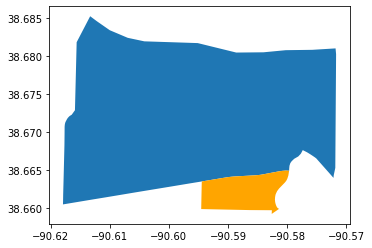

In [11]:
print(shapefiles_census[shapefiles_census["unique_ID"]=="189CHE018"])

ax = shapefiles_census[shapefiles_census["VTDST"]=="CHE018"].plot()
shapefiles_census[shapefiles_census["VTDST"]=="CH1605"].plot(ax = ax,color="orange")

     STATEFP COUNTYFP   VTDST NAMELSAD VTDI LSAD CHNG_TYPE ORIG_NAME  \
2943      29      189  0NW006    NW006    A   00      None      None   
3897      29      189  NW1604    NW006    A   00      None      None   

     ORIG_CODE RELATE   NAME VINTAGE FUNCSTAT JUSTIFY  MTFCC  \
2943      None   None  NW006      90        N    None  G5240   
3897      None   None  NW006      90        N    None  G5240   

                                               geometry unique_ID  
2943  POLYGON Z ((-90.47419 38.78762 0.00000, -90.47...  189NW006  
3897  POLYGON Z ((-90.37090 38.80798 0.00000, -90.37...  189NW006  
Empty DataFrame
Columns: [unique_ID, COUNTYFP, precinct, G18USSDMCC, G18USSIODE, G18AUDGFIT, G18AUDCLUE, G18USSLCAM, G18USSGCRA, G18USSRHAW, G18AUDDGAL, G18AUDRMCD, G18AUDLOTO]
Index: []


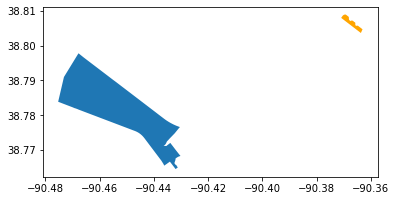

In [12]:
print(shapefiles_census[shapefiles_census["unique_ID"]=="189NW006"])

ax = shapefiles_census[shapefiles_census["VTDST"]=="0NW006"].plot()
shapefiles_census[shapefiles_census["VTDST"]=="NW1604"].plot(ax = ax,color="orange")

print(elections_census_shapes[elections_census_shapes["unique_ID"]=="189NW006"])

### Name Changes to Join Election Results to Precincts

Note: All name changes and mergers below were determined by examining the names side by side and making changes as necessary. In checking the election results, I sometimes looked at VEST's final file to see what name changes they made if it was not clear.

In [13]:
census_name_changes_dict = {"003Savannah Southeast":"003Southeast"
                            ,"003Savannah Southwest":"003Southwest",
 "017Drum-Dongola":"017Drum Dungola",
 "021Bible Baptist Temple":"021Riverside Baptist Church",
'037No. 1 - Sherman':'03701 Sherman',
'037No. 7 - Coldwater':'03707 Drexel',
'037No. 10 - Grand River':'03710 Grand River Rural',
'037No. 11 - Grand River, Ward 1':'03711 Harrisonville Ward 1',
'037No. 12 - Grand River, Ward 2':'03712 Harrisonville Ward 2',
'037No. 13 - Grand River, Ward 3':'03713 Harrisonville Ward 3',
'037No. 14 - Grand River, Ward 4':'03714 Harrisonville Ward 4',
'037No. 19 - Polk':'03719 Polk',
'037No. 20 - Pleasant Hill':'03720 Pleasant Hill',
'037No. 21 - Pleasant Hill':'03721 Pleasant Hill East',
'037No. 22 - Pleasant Hill':'03722 Pleasant Hill',
'037No. 23 - Pleasant Hill':'03723 Pleasant Hill Rural',
'037No. 24 - Peculiar':'03724 Peculiar Rural',
'037No. 25 - West Peculiar':'03725 West Peculiar Rural',
'037No. 26 - West Peculiar':'03726 West Peculiar City',
'037No. 27 - Union':'03727 Union',
'037No. 28 - Big Creek':'03728 Big Creek Rural',
'037No. 29 - Big Creek':'03729 Winnebago',
'037No. 30 - Raymore':'03730 Raymore Rural',
'037No. 31 - Raymore, Ward 3':'03731 Raymore Ward 3',
'037No. 32 - Raymore, Ward 2':'03732 Raymore Ward 2',
'037No. 33 - Raymore, Ward 2':'03733 Raymore Ward 2',
'037No. 34 - Raymore, Wards 3 & 4':'03734 Raymore Wards 3 & 4',
'037No. 35 - Raymore, Ward 4':'03735 Raymore Ward 4',
'037No. 36 - Kansas City':'03736 Mt Pleasant Rural',
'037No. 37 - Mt Pleasant':'03737 Pleasant Prairie',
'037No. 38 - Mt Pleasant, NE Ward 1':'03738 Belton NE Ward 1',
'037No. 39 - Mt Pleasant, NE Ward 1':'03739 Belton NE Ward 1',
'037No. 40 - Mt Pleasant, NW Ward 2':'03740 Belton NW Ward 2',
'037No. 41 - Mt Pleasant, NW Ward 2':'03741 Belton NW Ward 2',
'037No. 42 - Mt Pleasant, SW Ward 3':'03742 Belton SW Ward 3',
'037No. 43 - Mt Pleasant, SW Ward 3':'03743 Belton SW Ward 3',
'037No. 44 - Mt Pleasant, SW Ward 4':'03744 Belton SW Ward 4',
'037No. 45 - Mt Pleasant, SE Ward 4':'03745 Belton SE Ward 4',
'037No. 46 - Mt Pleasant':'03746 East Creek',
'037No. 47 - Raymore, Ward 1':'03747 Raymore Ward 1',
'145Neosho No. 3':'145Neosho #3',
 "043Cassidy":"043Cassidy 1","510ST 1-4":"510STL 1-4",
'181Flatwoods & Johnson P2 & Washington':'181Flatwoods/Johnson P2/Washington',
'181Gatewood & Union':'181Gatewood/Union',
'181Harris & Varner P1':'181Harris/Varner P1',
'181Shirley & Kelly & Pine':'181Shirley/Kelly/Pine',
'181Thomas & Varner P2':'181Thomas/Varner P2'}


shapefiles_census["unique_ID"] = shapefiles_census["unique_ID"].map(census_name_changes_dict).fillna(shapefiles_census["unique_ID"])


In [14]:
#Get CRS and cut down columns
shapefiles_census_crs = shapefiles_census.crs
shapefiles_census = shapefiles_census[['geometry', 'unique_ID']]

### Precinct Merger Code

In [15]:
dict_func_calls = {'03716 East Lynne/18 Gunn City':["037No. 16 - Camp Branch","037No. 18 - Index"],
'03702 Dayton/03 Garden City/15 Camp Branch/17 Index':['037No. 2 - Dayton','037No. 3 - Garden City','037No. 15 - Camp Branch','037No. 17 - Index'],
'03704 Austin/05 Archie/06 Everett':["037No. 4 - Austin","037No. 5 - Austin","037No. 6 - Everett"],
'03708 West Dolan/09 Dolan':["037No. 8 - West Dolan","037No. 9 - Dolan"],
'1591st Ward':['1591st Ward 1st Precinct','1591st Ward 2nd Precinct','1591st Ward 3rd Precinct'],
'1592nd Ward':['1592nd Ward 3rd Precinct','1592nd Ward 1st Precinct','1592nd Ward 2nd Precinct'],
'1593rd Ward':['1593rd Ward 1st Precinct','1593rd Ward 2nd Precinct','1593rd Ward 3rd Precinct'],
'1594th Ward':['1594th Ward 1st Precinct','1594th Ward 2nd Precinct','1594th Ward 3rd Precinct'],
'159Smithton W BP/Smithton E & W/Lake Creek':['159Smithton E & W/Lake Creek','159Smithton W BP' ],
'181Poynor/Current River/West Doniphan/Doniphan P1/Doniphan P2':['181Doniphan P1 & Doniphan P2','181Poynor & Current River & West Doniphan'],
'185Appleton':['185Appleton No. 1','185Appleton No. 2'],
'185Butler':['185Butler East','185Butler West'],
'185Collins/Washington':['185Collins','185Washington'],
'185Dallas/Doyal':['185Dallas','185Doyal'],
'185Monegaw/Osage':['185Monegaw','185Osage'],
'185Osceola/Polk':['185Osceola East','185Osceola West','185Polk'],
'185Center/Roscoe':[ '185Center','185Roscoe'],
'185Speedwell/Taber':['185Speedwell','185Taber'],
'187Farmington No. 4/Busiek':['187Busiek','187Farmington No. 4'],
'197Coffey/Downing':['197Coffey','197Downing'],
'197North Liberty/Coatsville/Glenwood/South Liberty':['197Coatsville','197Glenwood','197North Liberty','197South Liberty'],
'197East Prairie/West Prairie':['197East Prairie','197West Prairie'],
'203Spring Creek/Birch Tree/Bartlett':['203Spring Creek','203Bartlett','203Birch Tree'],
'203Eminence/Delaware':['203Delaware','203Eminence'],
'205BETHEL/TIGER FORK':['205Bethel/Tiger Fork',],
'207Bloomfield Ward No. 1/2':['207Bloomfield Ward No. 2','207Bloomfield Ward No. 1'],
'211Green City/Pennville':['211Green City','211Pennville'],
'211Taylor/Humphreys':['211Taylor','211Humphreys'],
'211Pollock/Boynton':['211Boynton','211Pollock'],
'211South Polk/Reger/Pleasant Hill':['211Reger','211South Polk','211Pleasant Hill'],
'211West Polk/Asbury':['211West Polk','211Asbury'],
"223Peach Tree/Piedmont Ward 1/Ward 2":['223Peach Tree','223Piedmont Ward No. 1','223Piedmont Ward No. 2'],
"223Wappapello/McGee/Shook":['223Wappapello','223McGee','223Shook'],
"223Coldwater/Greenville/Silva":['223Coldwater','223Greenville','223Silva'],
"223Cool Springs/Chaonia":['223Chaonia','223Cool Springs'],
"223Lowndes/Hiram":['223Lowndes','223Hiram'],
"223Patterson/Brunot/Smith Mill":['223Patterson','223Smith Mill','223Brunot'],
"223Cascade/Clubb":['223Clubb','223Cascade'],
"225East Ozark/Northview A":["225Northview A","225East Ozark"],
"225Finley/Hazelwood":["225Finley","225Hazelwood"],
"225Niangua/Union":["225Niangua","225Union"],
"225Washington/Grant":["225Washington","225Grant"]}

In [16]:
def precinct_merger(precinct_list,new_precinct):
    global shapefiles_census
    prec_holder = []
    for i in precinct_list:
        prec_holder.append(shapefiles_census.loc[shapefiles_census["unique_ID"]==i])
    new_geom = pd.concat(prec_holder, ignore_index=True).unary_union
    new_prec = gp.GeoDataFrame(geometry=[new_geom],columns=["geometry","unique_ID"],crs = shapefiles_census_crs)
    new_prec["unique_ID"]=new_precinct
    shapefiles_census = shapefiles_census.append(new_prec)
    shapefiles_census = shapefiles_census[~shapefiles_census["unique_ID"].isin(precinct_list)]

for val in dict_func_calls:
    precinct_merger(dict_func_calls[val],val)

In [17]:
county_fips_code_list = ["003","009","015","017","019","035","043","143","189"]
filtered_census = elections_census_shapes[elections_census_shapes["unique_ID"].str[0:3].isin(county_fips_code_list)]["unique_ID"]
for val in filtered_census:
    if "/" in val:
        pieces = val.split("/")
        fips = pieces[0][0:3]
        holder = []
        holder.append(pieces[0])
        for i in range(1,len(pieces)):
            holder.append(fips+pieces[i])
        precinct_merger(holder,val)

In [18]:
#Attempt to join on the "unique_ID" column
census_join = pd.merge(elections_census_shapes,shapefiles_census,how="outer",on="unique_ID",indicator=True)
print(census_join["_merge"].value_counts())
#census_join[census_join["_merge"]=="left_only"].to_csv("./census_join/election.csv")
#census_join[census_join["_merge"]=="right_only"].to_csv("./census_join/shapes.csv")

both          2088
right_only     337
left_only      171
Name: _merge, dtype: int64


Documentation (modifications not attempted)
--------

Precinct mergers were made in the following counties to match county reporting units: 
- Andrew: Precinct mergers to match county reporting units
- Barry: Precinct mergers to match county reporting units
- Barry: Add Monett City; Align Cassville with corporate boundary
- Barton: Adjust Lamar ward boundaries to match city map
- Benton: Precinct mergers to match county reporting units
- Bollinger: Precinct mergers to match county reporting units
- Bollinger: Adjust Patton/Sedgewickville to match county GIS
- Butler: Align Poplar Bluff with corporate boundary and adjust wards to match city map
- Boone: Precinct mergers to match county reporting units
- Carroll: Precinct mergers to match county reporting units
- Carroll: Adjust Carrollton City wards to match voter file
- Carter: Precinct mergers to match county reporting units
- Cass: Precinct mergers to match county reporting units
- Cass: Align Belton, Pleasant Hill, Raymore precincts with corporate boundaries; Adjust 37 Pleasant Prairie/25 West Peculiar Rural
- Chariton: Adjust Salisbury wards to match city map
- Christian: Revise Cassidy 1/Cassidy 2; Reverse Nixa City annexation into Rosedale 1B
- Christian: Precinct mergers to match county reporting units
- Clark: Precinct mergers to match county reporting units
- Clay: Adjust Excelsior Springs, Kearney, Smithville precincts to match 2018 ward and corporate boundaries; Adjust KC 21-1/15, 21-1/17, 21-3/11, 21-4/6, 21-4/11, 21-5/7/24, 21-6/24, 21-7/20, 21-13/26, 21-14/23, 21-17/16, 21-17/26, 21-17/Platte 1, Gallatin 7/16, 10/13, 10/16, 11/15, 13/15, Kearney 3/Platte 2, Liberty 1/10, 6/13, 7/11, 11/14, Washington 1/3 to match voter file
- Clinton: Align Atchison/Concord, Jackson/Lathrop with 2018 precinct split assignments
- Cole: Precinct mergers to match county reporting units
- Cole: Adjust Marion Twp St Martins to include St Martins city in Jefferson Twp
- Crawford: Move Benton Twp section of Leasburg precinct from Recklein to Leasburg
- Crawford: Precinct mergers to match county reporting units
- Dade: Realign Greenfield wards to match municipal code
- Dallas: Split N Benton Inside/OCL, S Benton Inside/OCL; Align N/S Benton with Buffalo ward map
- Dallas: Precinct mergers to match county reporting units
- Dekalb: Precinct mergers to match county reporting units
- Dent: Split Boss precinct from R-4 precinct; Adjust R-2/R-3 boundary
- Douglas: Precinct mergers to match county reporting units
- Dunklin: Precinct mergers to match county reporting units
- Dunklin: Align Holcomb, Rives with township boundaries; Adjust Arbyrd/Senath; Align Kennett wards with city map
- Gasconade: Align Hermann, Owensville, Rosebud with corporate boundaries and ward descriptions
- Gentry: Precinct mergers to match county reporting units
- Grundy: Precinct mergers to match county reporting units
- Holt: Precinct mergers to match county reporting units
- Holt: Split West between Central/Northwest by school district
- Howard: Precinct mergers to match county reporting units
- Howell: Precinct mergers to match county reporting units
- Howell: Align West Plains precincts with 2018 corporate boundary
- Iron: Adjust Annapolis/Des Arc/Vulcan, Ironton/Pilot Knob
- Johnson: Adjust Warrensburg NE/NW boundary to match county maps
- Johnson: Precinct mergers to match county reporting units
- Lewis: Split LaBelle Twp between LaBelle FS/Lewistown FS with PLSS grid
- Lincoln: Align Moscow Mills, Troy with 2018 corporate boundaries; Adjust Briscoe/Troy Rural
- Linn: Precinct mergers to match county reporting units
- Linn: Split Brookfield Township between Brookfield 1&2/3&4
- Livingston: Align Chillicothe with 2018 corporate boundaries
- Livingston: Precinct mergers to match county reporting units
- Macon: Align Macon City wards with corporate boundaries
- Madison: Align Fredericktown wards with corporate boundaries
- Mercer: Precinct mergers to match county reporting units
- Mississippi: Precinct mergers to match county reporting units
- Mississippi: Adjust Bertrand/East Prairie Rural; Align East Prairie City with corporate boundary
- Moniteau: Precinct mergers to match county reporting units
- Montgomery: Align Bellflower/Middletown, Big Spring/Rhineland with voter file
- Morgan: Adjust Versaille North/South boundary to match county GIS
- Morgan: Precinct mergers to match county reporting units
- New Madrid: Precinct mergers to match county reporting units
- New Madrid: Add New Madrid City wards; Add Big Prairie 4 precinct; Move Portageville Ward 1 to Portage 1
- Newton: Align Staples precincts with Joplin City GIS boundaries; Align Neosho precincts with Neosho City GIS boundaries; Adjust Newtonia/Ritchey Wentworth
- Oregon: Precinct mergers to match county reporting units
- Pettis: Precinct mergers to match county reporting units
- Pettis: Adjust Sedalia City wards to match city map
- Phelps: Align St. James ward boundaries with city map
- Phelps: Precinct mergers to match county reporting units
- Polk: Precinct mergers to match county reporting units
- Polk: Split Campbell/Jefferson precincts by school district
- Putnam: Split Union Twp into NE/SW precincts to match county map
- Putnam: Precinct mergers to match county reporting units
- Pulaski: Adjust Big Piney/St. Roberts, Laquey/Waynesville
- Ralls: Precinct mergers to match county reporting units
- Ralls: Replace Center/Liberty precincts with 2010 VTDs
- Ray: Adjust Richmond City wards, Homestead Village/Wood Heights/Lawson, Richmond/Orrick
- Ray: Precinct mergers to match county reporting units
- Reynolds: Realign precincts countywide to match voter file
- Ripley: Precinct mergers to match county reporting units
- Saline: Split Nelson precinct from Hardeman precinct; Adjust Marshall Ward 2/3 boundary
- St. Charles: Adjust Brian/Ridgepoint, Civic/St. Paul, Harvester/Sycamore, Mamelle/Marina
- St. Clair: Precinct mergers to match county reporting units
- St. Francois: Precinct mergers to match county reporting units
- St. Francois: Align Desloge, Farmington, Park Hills with corporate boundaries and city ward maps; Adjust Bonne Terre/Timberline, Patterson/Timberline, Leadwood/Park Hills to match voter file
- St. Louis: Precinct mergers to match county reporting units
- St. Louis: Add UNV044 precinct; Split NRW011/NRW052
- Schuyler: Precinct mergers to match county reporting units
- Shannon: Precinct mergers to match county reporting units
- Shannon: Align all precincts with county GIS and voter file
- Shelby: Precinct mergers to match county reporting units
- Shelby: Adjust Jackson/North River to match voter file
- Stoddard: Precinct mergers to match county reporting units
- Stoddard: Align Advance, Bernie, Bloomfield, Dexter, Puxico with corporate boundaries; Adjust Advance/Leora, Bernie/Dexter/Pyle, Bloomfield/Gray Ridge
- Stone: Move Branson West from Ruth A to Ruth C; Split Ruth C Rural/Sunset Cove; Adjust Ruth B City/Rural to match county GIS
- Sullivan: Precinct mergers to match county reporting units
- Taney: Adjust Boston Center/Walnut Shade; Align Branson wards with 2018 corporate boundary
- Vernon: Align Bronaugh/Moundville, Harwood/Schell City, Deerfield/NG Armory with voter file
- Wayne: Precinct mergers to match county reporting units
- Webster: Precinct mergers to match county reporting units





### 2. 2010 Census VTD release
>Monroe County comes from the 2010 Census VTD release.

https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2010&layergroup=Voting+Districts

In [19]:
monroe_shape = gp.read_file("./raw-from-source/Census/2010_VTD/tl_2010_29137_vtd10/tl_2010_29137_vtd10.shp")

### 3. 2020 Census VTD release
>Platte County comes from the 2020 Census VTD release.

https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2020.html

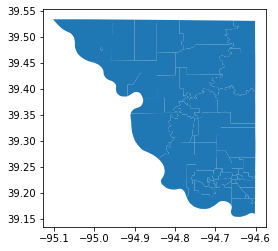

In [20]:
platte_shape = gp.read_file("./raw-from-source/Census/2020_VTD/tl_2020_29_all/tl_2020_29165_vtd20.shp")
platte_shape.plot()

- Platte: Precinct mergers to match county reporting units
- Platte: Align Lake Waukomis, Parkville, Platte City, Riverside/Northmore, Weatherby Lake with corporate boundaries; Adjust Platte Hills/Park Hill, Seven Bridges/Shiloh

### 4. Counties themselves
> The following counties instead used maps or shapefiles sourced from the respective county governments:  
Audrain, Bates, Caldwell, Callaway, Camden, Cape Girardeau, Cedar, Cooper, Franklin, Greene, Jackson, Jasper, Jefferson, Laclede, Lafayette, Lawrence, Marion, McDonald, Miller, Nodaway, Osage, Ozark, Pemiscot, Pike, Randolph, Scott, Ste. Genevieve, Texas, Warren, Washington, Worth, Wright.  

Able to find shapefiles for Camden, Cooper, Marion, Lafayette, Laclede, Jasper, Bates, Audrain.  

Of these, only Jasper came in shapefile format. The others came in tif formats that I was unable to load into this notebook without digitizing.

In [21]:
jasper_shape = gp.read_file("./raw-from-source/Counties/Jasper/Voting_Precincts_2020-shp/Voting_Precincts_2020.shp")
print(jasper_shape.shape)

(74, 10)


- Audrain: https://audraingis.integritygis.com/H5/Index.html?viewer=audrain
- Bates: https://batesgis.integritygis.com/H5/Index.html?viewer=bates
- Caldwell: can't find
- Callaway: can't find
- Camden: https://camdengis.integritygis.com/H5/Index.html?viewer=camden
- Cape Girardeau: only pdf (https://capecountyelections.com/wp-content/uploads/2019/06/Voter_Precincts.pdf)
- Cedar: can't find
- Cooper: https://coopergis.integritygis.com/H5/Index.html?viewer=cooper
- Franklin: can't find
- Greene: not available (https://www.greenecountyassessor.org/assessor/maps/mapadv.aspx)
- Jackson: not downloadable (https://jcebmo.org/wp-content/uploads/JACKSON-COUNTY-TOWNSHIPS-PRECINCTS.pdf)
- Jasper: https://jaspercountymogisintiatives-jcmo.hub.arcgis.com/datasets/voting-precincts-2020
- Jefferson: can't find
- Laclede: https://lacledegis.integritygis.com/H5/Index.html?viewer=laclede
- Lafayette: https://lafayettegis.integritygis.com/H5/Index.html?viewer=lafayette
- Lawrence: not downloadable (https://www.lawrencecountymo.org/elections)
- Marion: https://mariongis.integritygis.com/H5/Index.html?viewer=marion_public
- McDonald: can't find
- Miller: not available (https://millergis.integritygis.com/H5/Index.html?viewer=miller)
- Nodaway: can't find
- Osage: can't find
- Ozark: can't find
- Pemiscot: can't find
- Pike: can't find
- Randolph: can't find
- Scott: not downloadable https://www.arcgis.com/apps/webappviewer/index.html?id=73de0cc0034040a5b8b0f5988a643164
- Ste. Genevieve: can't find
- Texas: can't find
- Warren: not downloadable (https://www.arcgis.com/apps/webappviewer/index.html?id=edfaf72f348b4ea28a959815d82dfe86)
- Washington: can't find
- Worth: can't find
- Wright: can't find

### Shapefile Modifications

- Audrain: Precinct mergers to match county reporting units
- Audrain: Add Vandalia City; Align Mexico precincts with municipal code
  
- Callaway: Align Fulton, Holts Summit precincts with 2018 corporate boundaries
- Callaway: Precinct mergers to match county reporting units

- Camden: Precinct mergers to match county reporting units

- Cape Girardeau: Precinct mergers to match county reporting units

- Cooper: Precinct mergers to match county reporting units

- Franklin: Split Dry Branch between Stanton & St. Clair Out of Town
- Franklin: Precinct mergers to match county reporting units

- Greene: Precinct mergers to match county reporting units

- Jackson: Precinct mergers to match county reporting units

- Jasper: Precinct mergers to match county reporting units
- Jasper: Realign Carthage 2/3, Joplin 1/7, 10/13, 10/15, 13/22, Oronogo 1/2, Webb City 1/4 to match city ward maps

- Jefferson: Precinct mergers to match county reporting units
- Jefferson: Split Festus Ward 1 P1/P2, Ward 3 P1/P2, Ward 4 P1/P2; Adjust Crystal City/Riverview

- Marion: Precinct mergers to match county reporting units
- Marion: Split Fabius-Smileyville/Taylor, Warren-Monroe City/Warren; Align Hannibal wards with voter file

- Miller: Adjust all precinct boundaries to match voter file

- Nodaway: Precinct mergers to match county reporting units

- Osage: Precinct mergers to match county reporting units

- Pemiscot: Precinct mergers to match county reporting units

- Pike: Adjust Cuivre JL boundaries with Ashley NO, Buffalo E, Prairieville I

- Randolph: Precinct mergers to match county reporting units

- Scott: Adjust Haywood City/Morley, Sikeston Ward 1/McMullin/Vanduser

- Warren: Precinct mergers to match county reporting units

- Washington: Adjust City Hall/Stony Point, Cruise/Richwoods to match county GIS

- Worth: Precinct mergers to match county reporting units

### Attempt to join election results to precincts from these 3 counties

In [22]:
#Platte County
platte_shape["unique_ID"] = "165"+platte_shape["NAME20"]
platte_shape["unique_ID"] = platte_shape["unique_ID"].str.strip()
platte_shape = platte_shape[["unique_ID","geometry"]]

#Monroe County
monroe_shape["unique_ID"] = "137"+monroe_shape["NAME10"]
monroe_shape["unique_ID"] = monroe_shape["unique_ID"].str.strip()
monroe_shape = monroe_shape[["unique_ID","geometry"]]

#Jasper County
jasper_shape["unique_ID"] = "097"+jasper_shape["Precinct"]
jasper_shape["unique_ID"] = jasper_shape["unique_ID"].str.strip()
jasper_shape = jasper_shape[["unique_ID","geometry"]]

#Create a merged dataframe with these 3
counties_shapes = pd.concat([platte_shape,monroe_shape,jasper_shape], axis=0, ignore_index=True)

county_list = ["Platte", "Monroe","Jasper"]
fips_to_take = fips_file[fips_file["County Name"].isin(county_list)]
different_source = fips_to_take["FIPS County"].tolist()
elections_counties_shapes =  joined[joined["COUNTYFP"].isin(different_source)]

### Precinct name change and merger code

In [24]:
def precinct_merger_2(precinct_list,new_precinct):
    global counties_shapes
    prec_holder = []
    for i in precinct_list:
        prec_holder.append(counties_shapes.loc[counties_shapes["unique_ID"]==i])
    new_geom = pd.concat(prec_holder, ignore_index=True).unary_union
    new_prec = gp.GeoDataFrame(geometry=[new_geom],columns=["geometry","unique_ID"],crs = shapefiles_census_crs)
    new_prec["unique_ID"]=new_precinct
    counties_shapes = counties_shapes.append(new_prec)
    counties_shapes = counties_shapes[~counties_shapes["unique_ID"].isin(precinct_list)]

In [25]:
name_changes = {"097Duenweg Ward 2":"097Duenweg",'097Jackson West_new':'097Jackson West',"137Monroe City 1, 2, & 3/Indian Creek 4":"137Monroe City 1 & 2 & 3/Indian Creek 4","165South-East 37":"165Southeast 27"}
dict_func_calls = {'097Carterville Wards 1-4':["097Carterville - Ward 1","097Carterville - Ward 2","097Carterville - Ward 3","097Carterville - Ward 4"],
                  '097Sarcoxie 1-2':['097Sarcoxie 2','097Sarcoxie 1'],
                  '097Jackson West_new':['097Jackson West']}

for val in dict_func_calls:
    precinct_merger_2(dict_func_calls[val],val)
    
    
#First call on dict_func, then 097, contains "/"
counties_shapes["unique_ID"] = counties_shapes["unique_ID"].map(name_changes).fillna(counties_shapes["unique_ID"])

In [26]:
county_fips_code_list = ["097","165"]
filtered_census = elections_counties_shapes[elections_counties_shapes["unique_ID"].str[0:3].isin(county_fips_code_list)]["unique_ID"]
for val in filtered_census:
    if "/" in val:
        pieces = val.split("/")
        fips = pieces[0][0:3]
        holder = []
        holder.append(pieces[0])
        for i in range(1,len(pieces)):
            holder.append(fips+pieces[i])
            #print(holder)
        precinct_merger_2(holder,val)

In [27]:
#Attempt to join on the "unique_ID" column
county_join = pd.merge(elections_counties_shapes,counties_shapes,how="outer",on="unique_ID",indicator=True)
print(county_join["_merge"].value_counts())
print(county_join[county_join["_merge"]=="both"]["unique_ID"].value_counts())
#county_join[county_join["_merge"]=="left_only"].to_csv("./county_join/election.csv")
#county_join[county_join["_merge"]=="right_only"].to_csv("./county_join/shapes.csv")

both          81
right_only     0
left_only      0
Name: _merge, dtype: int64
165Parkville 5                                    1
097Joplin 10/Joplin 11                            1
165Barry East 34                                  1
097Carthage 2                                     1
165Riverside 1/Northmoor 3                        1
                                                 ..
097Carterville Wards 1-4                          1
097Carthage 5                                     1
165Farley-Stillings 12                            1
165Ferrelview 30/Mid-Continent 31/Linkville 33    1
165Embassy 11                                     1
Name: unique_ID, Length: 81, dtype: int64


## Validation of precincts with election results + shapefiles

In [28]:
li = [county_join[county_join["_merge"]=="both"],census_join[census_join["_merge"]=="both"]]
final_source = gp.GeoDataFrame(pd.concat(li))
print(final_source.shape)

(2169, 15)


In [29]:
full_file = pd.merge(vest_mo_18,final_source,how="outer",on="unique_ID",indicator="final_ind")
print(full_file["final_ind"].value_counts())
both = full_file[full_file["final_ind"]=="both"]
both.reset_index(inplace=True)

both          2169
left_only     1073
right_only       0
Name: final_ind, dtype: int64


In [30]:
source_shapes = gp.GeoDataFrame(both, geometry='geometry_x')
vest_shapes = gp.GeoDataFrame(both, geometry='geometry_y')
vals = source_shapes.geom_almost_equals(vest_shapes,decimal=0)

In [31]:
print(vals.value_counts())

True     1192
False     977
dtype: int64


189    273
047     66
183     59
097     42
019     40
      ... 
089      1
067      1
087      1
063      1
133      1
Name: unique_ID, Length: 73, dtype: int64


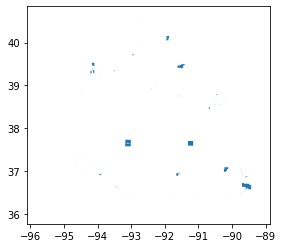

In [32]:
print(both[~vals]["unique_ID"].str[0:3].value_counts())
diff_precincts = gp.GeoDataFrame(both[~vals], geometry='geometry_x',crs=shapefiles_census_crs)

shp_difference = gp.overlay(source_shapes,vest_shapes,how='symmetric_difference')
shp_difference.plot()

      index STATEFP COUNTYFP_x  \
0         0      29        189   
2         3      29        043   
4         5      29        189   
5         8      29        165   
7        10      29        135   
...     ...     ...        ...   
2164   3230      29        097   
2165   3232      29        043   
2166   3234      29        189   
2167   3235      29        189   
2168   3238      29        189   

                                                   NAME  G18USSRHAW_x  \
0                                                 MR032            77   
2                                           West Finley          1254   
4                                         MID004/MID053           234   
5                                         Barry East 34           953   
7                                      California No. 3           517   
...                                                 ...           ...   
2164                                          Oronogo 1           589   
2165   

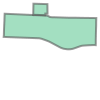

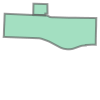

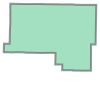

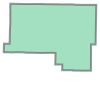

In [33]:
#Show a random difference
test = both[~vals].sample(axis=0,n=1).index[0]
print(both[~vals])
display(both.iloc[test]["geometry_x"])
display(both.iloc[test]["geometry_y"])

test = both[~vals].sample(axis=0).index[0]
display(both.iloc[test]["geometry_x"])
display(both.iloc[test]["geometry_y"])

### Look into county w/ FIPS 189

(836, 31)


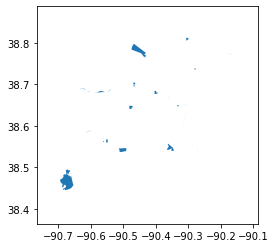

In [34]:
print(both[both["unique_ID"].str[0:3]=="189"].shape)
kc_1 = gp.GeoDataFrame(both[both["unique_ID"].str[0:3]=="189"], geometry='geometry_x',crs=shapefiles_census_crs)
kc_2 = gp.GeoDataFrame(both[both["unique_ID"].str[0:3]=="189"], geometry='geometry_y',crs=shapefiles_census_crs)

gp.overlay(kc_1,kc_2,how='symmetric_difference').plot()

In [35]:
col_list = ["G18USSDMCC","G18USSIODE","G18AUDGFIT","G18AUDCLUE","G18USSLCAM","G18USSGCRA","G18USSRHAW","G18AUDDGAL","G18AUDRMCD","G18AUDLOTO"]
validater_row(both,col_list)

New max diff is:  1.0
043West Finley
New max diff is:  2.0
0194K/4M/37
There are  2169  total rows
605  of these rows have election result differences
1564  of these rows are the same

The max difference between any one shared column in a row is:  2.0
The average difference is:  1.0208926875593543
There are  0 precinct results with a difference greater than 5
